# Palau

In [1]:
import os
os.chdir("../")
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pmdarima import model_selection
from pmdarima import auto_arima
from scripts.python.ts_utils import * 
from scripts.python.tsmodel import * 
from scripts.python.ts_eval import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
palau_folder = os.getcwd() + "/data/tourism/palau/"

In [3]:
palau_va = (pd.read_csv(palau_folder + "model/palau_for_utsa.csv")
              .drop("Unnamed: 0", axis=1))
palau_va.head(5)

,Date,JAPAN,SOUTH KOREA,TAIWAN,CHINA,USA/CANADA,EUROPE,OTHERS,Total,palau_travel,year,month,covid
0,2007-06-01,856.0,1291.0,3245.0,86.0,669.0,99.0,463.0,6709.0,0.320004,0.0,0.0,0.0
1,2007-07-01,2119.0,1366.0,3269.0,33.0,653.0,144.0,437.0,8021.0,0.952482,0.0,0.0,0.0
2,2007-08-01,3476.0,1354.0,3046.0,46.0,580.0,256.0,438.0,9196.0,0.453967,0.0,0.0,0.0
3,2007-09-01,3022.0,910.0,2497.0,61.0,559.0,145.0,401.0,7595.0,0.000000,0.0,0.0,0.0
4,2007-10-01,1807.0,1082.0,2298.0,49.0,774.0,390.0,395.0,6795.0,0.000000,0.0,0.0,0.0


## Benchmark Methods

In [4]:
naive_pred = naive_method(palau_va["Total"])
mean_pred = mean_method(palau_va["Total"])
snaive_pred = seasonal_naive_method(palau_va["Total"])

benchmark = pd.DataFrame()
for idx, method in enumerate([naive_pred, mean_pred, snaive_pred]):
    metrics = calculate_evaluation(palau_va["Total"], method)
    metrics_df = pd.DataFrame(metrics, index=[idx])
    benchmark = pd.concat([benchmark, metrics_df], axis=0)

benchmark.index = ["naive", "mean", "seasonal naive"]
benchmark

,MSE,RMSE,MAE,MAPE
naive,2.096767e+06,1448.021907,1092.759563,323.392324
mean,1.639656e+07,4049.266859,3178.648757,8859.425305
seasonal naive,1.123704e+07,3352.169852,2405.935201,8120.993038


## SARIMAX

In [5]:
pw = SARIMAXPipeline(data=palau_va, y_var="Total",
                     exog_var=["covid", "palau_travel"], transform_method="scaledlogit")
pw.transform()

training size : 165, testing size : 19


<AxesSubplot:>

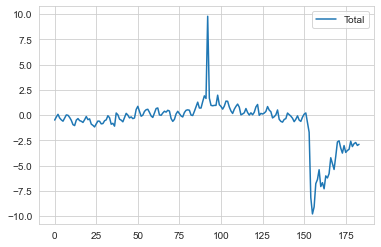

In [6]:
pw.transformed_y.plot()

In [7]:
help(pw.stepwise_search)

Help on method stepwise_search in module scripts.python.tsmodel:

stepwise_search(d: int = None, D: int = None) -> dict method of scripts.python.tsmodel.SARIMAXPipeline instance
    Perform stepwise search for the best SARIMAX model.
    
    Args: 
        d : the order of differencing
        D : the order of seasonal differencing
    
    Returns:
        dict: Dictionary containing the parameters of the best model.



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=495.109, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=494.742, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=480.126, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=461.639, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=492.765, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=463.008, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=462.007, Time=0.38 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=460.759, Time=0.10 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=460.706, Time=0.30 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=455.669, Time=0.55 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=455.863, Time=0.75 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=45

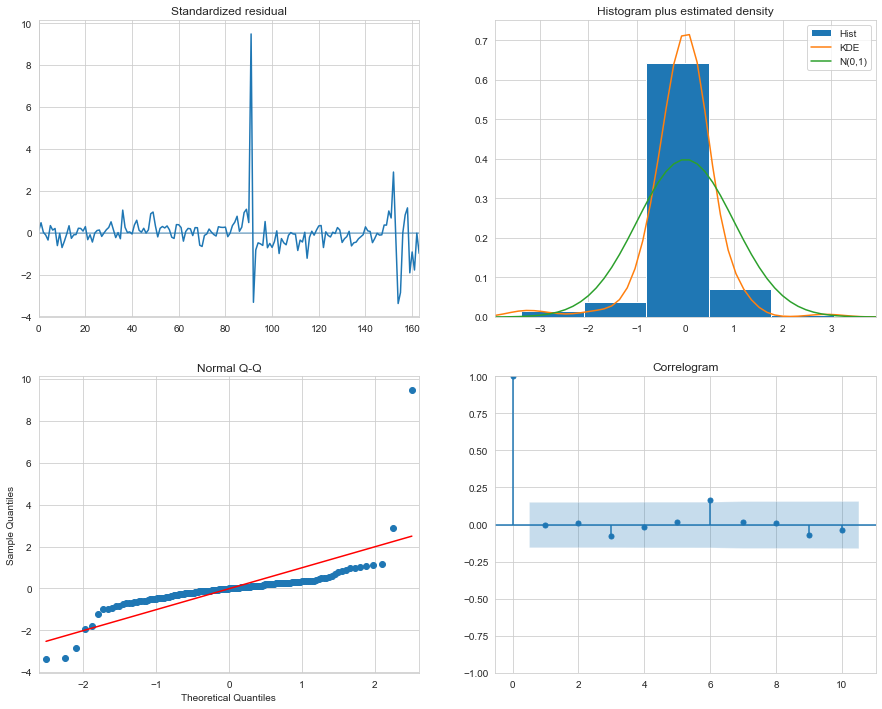

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (1, 1, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (1, 0, 1, 12),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

In [8]:
pw.stepwise_search()

In [9]:
# Set parameter range
p, d, q = range(0, 3), range(0, 2), range(0, 3)
P, D, Q, s = range(0, 3), range(0, 2), range(0, 3), [12]

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq, seasonal_pdq))

# Search the minimim aic
pw_msres = pw.manual_search(params=all_param)

Tried out SARIMAX(0, 0, 0)x(0, 0, 0, 12) - AIC:504.6
Tried out SARIMAX(0, 0, 0)x(0, 0, 1, 12) - AIC:494.47
Tried out SARIMAX(0, 0, 0)x(0, 0, 2, 12) - AIC:493.57
Tried out SARIMAX(0, 0, 0)x(0, 1, 0, 12) - AIC:511.9
Tried out SARIMAX(0, 0, 0)x(0, 1, 1, 12) - AIC:481.05
Tried out SARIMAX(0, 0, 0)x(0, 1, 2, 12) - AIC:481.04
Tried out SARIMAX(0, 0, 0)x(1, 0, 0, 12) - AIC:491.4
Tried out SARIMAX(0, 0, 0)x(1, 0, 1, 12) - AIC:491.79
Tried out SARIMAX(0, 0, 0)x(1, 0, 2, 12) - AIC:493.74
Tried out SARIMAX(0, 0, 0)x(1, 1, 0, 12) - AIC:492.37
Tried out SARIMAX(0, 0, 0)x(1, 1, 1, 12) - AIC:479.33
Tried out SARIMAX(0, 0, 0)x(1, 1, 2, 12) - AIC:480.44
Tried out SARIMAX(0, 0, 0)x(2, 0, 0, 12) - AIC:491.94
Tried out SARIMAX(0, 0, 0)x(2, 0, 1, 12) - AIC:493.75
Tried out SARIMAX(0, 0, 0)x(2, 0, 2, 12) - AIC:492.19
Tried out SARIMAX(0, 0, 0)x(2, 1, 0, 12) - AIC:486.38
Tried out SARIMAX(0, 0, 0)x(2, 1, 1, 12) - AIC:480.19
Tried out SARIMAX(0, 0, 0)x(2, 1, 2, 12) - AIC:480.76
Tried out SARIMAX(0, 0, 1)x(0, 

Tried out SARIMAX(1, 0, 2)x(1, 0, 2, 12) - AIC:451.3
Tried out SARIMAX(1, 0, 2)x(1, 1, 0, 12) - AIC:463.1
Tried out SARIMAX(1, 0, 2)x(1, 1, 1, 12) - AIC:435.43
Tried out SARIMAX(1, 0, 2)x(1, 1, 2, 12) - AIC:436.39
Tried out SARIMAX(1, 0, 2)x(2, 0, 0, 12) - AIC:452.61
Tried out SARIMAX(1, 0, 2)x(2, 0, 1, 12) - AIC:451.43
Tried out SARIMAX(1, 0, 2)x(2, 0, 2, 12) - AIC:452.31
Tried out SARIMAX(1, 0, 2)x(2, 1, 0, 12) - AIC:453.0
Tried out SARIMAX(1, 0, 2)x(2, 1, 1, 12) - AIC:437.4
Tried out SARIMAX(1, 0, 2)x(2, 1, 2, 12) - AIC:438.3
Tried out SARIMAX(1, 1, 0)x(0, 0, 0, 12) - AIC:480.38
Tried out SARIMAX(1, 1, 0)x(0, 0, 1, 12) - AIC:479.01
Tried out SARIMAX(1, 1, 0)x(0, 0, 2, 12) - AIC:479.59
Tried out SARIMAX(1, 1, 0)x(0, 1, 0, 12) - AIC:510.98
Tried out SARIMAX(1, 1, 0)x(0, 1, 1, 12) - AIC:450.88
Tried out SARIMAX(1, 1, 0)x(0, 1, 2, 12) - AIC:452.8
Tried out SARIMAX(1, 1, 0)x(1, 0, 0, 12) - AIC:478.18
Tried out SARIMAX(1, 1, 0)x(1, 0, 1, 12) - AIC:470.6
Tried out SARIMAX(1, 1, 0)x(1, 0, 2

Tried out SARIMAX(2, 1, 1)x(2, 1, 2, 12) - AIC:439.68
Tried out SARIMAX(2, 1, 2)x(0, 0, 0, 12) - AIC:452.34
Tried out SARIMAX(2, 1, 2)x(0, 0, 1, 12) - AIC:454.47
Tried out SARIMAX(2, 1, 2)x(0, 0, 2, 12) - AIC:455.45
Tried out SARIMAX(2, 1, 2)x(0, 1, 0, 12) - AIC:493.19
Tried out SARIMAX(2, 1, 2)x(0, 1, 1, 12) - AIC:436.3
Tried out SARIMAX(2, 1, 2)x(0, 1, 2, 12) - AIC:438.15
Tried out SARIMAX(2, 1, 2)x(1, 0, 0, 12) - AIC:453.79
Tried out SARIMAX(2, 1, 2)x(1, 0, 1, 12) - AIC:451.1
Tried out SARIMAX(2, 1, 2)x(1, 0, 2, 12) - AIC:452.92
Tried out SARIMAX(2, 1, 2)x(1, 1, 0, 12) - AIC:466.41
Tried out SARIMAX(2, 1, 2)x(1, 1, 1, 12) - AIC:437.99
Tried out SARIMAX(2, 1, 2)x(1, 1, 2, 12) - AIC:439.08
Tried out SARIMAX(2, 1, 2)x(2, 0, 0, 12) - AIC:454.61
Tried out SARIMAX(2, 1, 2)x(2, 0, 1, 12) - AIC:452.99
Tried out SARIMAX(2, 1, 2)x(2, 0, 2, 12) - AIC:454.14
Tried out SARIMAX(2, 1, 2)x(2, 1, 0, 12) - AIC:456.34
Tried out SARIMAX(2, 1, 2)x(2, 1, 1, 12) - AIC:439.92
Tried out SARIMAX(2, 1, 2)x(2,

In [10]:
# Display top five model params with the lowest AICs
pw_msres.sort(key=lambda x: x[1])
pw_msres[:5]

[(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x167cdb430>,
  432.6888172242761,
  ((1, 1, 1), (0, 1, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x169fa4f10>,
  432.93177621896336,
  ((0, 1, 2), (0, 1, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x323800880>,
  433.17575492530113,
  ((2, 0, 1), (0, 1, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x16befcd90>,
  433.4407618847055,
  ((1, 0, 2), (0, 1, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x169c73d90>,
  433.53063528216273,
  ((0, 1, 1), (0, 1, 1, 12)))]

In [11]:
# Construct a list of top models for cross-validation
pw_models = []

# Append the best model from stepwise_search()
pw_swm = pw.stepwise_model
pw_models.append(pm.ARIMA(
    pw_swm["order"], pw_swm["seasonal_order"],  exog=pw.exog[:pw.training_size]))

# Append top five GridSearch results
for res in pw_msres[:5]:
    order, seasonal_order = res[-1]
    model = pm.ARIMA(order, seasonal_order, exog=pw.exog[:pw.training_size])
    pw_models.append(model)

In [12]:
# Conduct model comparisons based on cross-validation
pw_comp = pw.compare_models(y=pw.transformed_y[:pw.training_size],
                            exog=pw.exog[:pw.training_size],
                            models=pw_models)
pw_comp

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] f

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] f

{'model': [ARIMA(order=(1, 1, 1), seasonal_order=(1, 0, 1, 12)),
  ARIMA(order=(1, 1, 1), seasonal_order=(0, 1, 1, 12)),
  ARIMA(order=(0, 1, 2), seasonal_order=(0, 1, 1, 12)),
  ARIMA(order=(2, 0, 1), seasonal_order=(0, 1, 1, 12)),
  ARIMA(order=(1, 0, 2), seasonal_order=(0, 1, 1, 12)),
  ARIMA(order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))],
 'cv_scores': [array([106.84907584,  69.17575204,  59.46283951,  93.92695356,
          91.5328029 , 163.31470591, 148.64533213, 167.10137747,
         180.91158619, 170.76577203, 172.62822017, 196.87461592,
         115.32507484,  53.36791049, 129.09521683, 193.60380046,
         121.16344171, 154.82443827, 154.7316949 , 138.35118655,
         114.29133923,  83.75223643, 182.02682155, 181.76198728]),
  array([ 59.46083747,  48.5008139 ,  54.62415759, 103.28969877,
         118.10870816, 161.92650478, 126.07084679, 101.90918207,
          88.43730345, 106.07581107, 171.83034237, 191.08560152,
         131.56954299,  51.33194005,  79.52073519,  62

In [13]:
best_pw = pw_msres[1][0]
best_pw_mod = pw.get_prediction_df(
    best_pw, 19, pw.exog[-pw.test_size:])
lower = palau_va["Total"].min() - 1
upper = palau_va["Total"].max() + 1

for col_idx, col in enumerate(best_pw_mod.columns):
    for row_idx, _ in enumerate(best_pw_mod[col]):
        best_pw_mod.iloc[row_idx, col_idx] = \
        pw.inverse_scaledlogit(best_pw_mod.iloc[row_idx, col_idx], upper, lower)

In [14]:
best_pw_mod = pd.concat([palau_va[["Date", "Total"]], best_pw_mod], axis=1)
best_pw_mod.head(20)

,Date,Total,train_pred,mean_se,mean_ci_lower,mean_ci_upper,test_pred
0,2007-06-01,6709.0,9014.209105,NaN,0.000000,NaN,NaN
1,2007-07-01,8021.0,7005.766606,NaN,0.000000,NaN,NaN
2,2007-08-01,9196.0,7777.401864,NaN,0.000000,NaN,NaN
3,2007-09-01,7595.0,8971.695406,NaN,0.000000,NaN,NaN
4,2007-10-01,6795.0,7595.000824,NaN,0.000000,NaN,NaN
5,2007-11-01,6252.0,7029.338556,NaN,0.000000,NaN,NaN
6,2007-12-01,7595.0,6028.952118,NaN,0.000000,NaN,NaN
7,2008-01-01,8911.0,8015.469905,NaN,0.000000,NaN,NaN
8,2008-02-01,8766.0,8751.406872,NaN,0.000000,NaN,NaN
9,2008-03-01,7817.0,9460.849009,NaN,0.000000,NaN,NaN


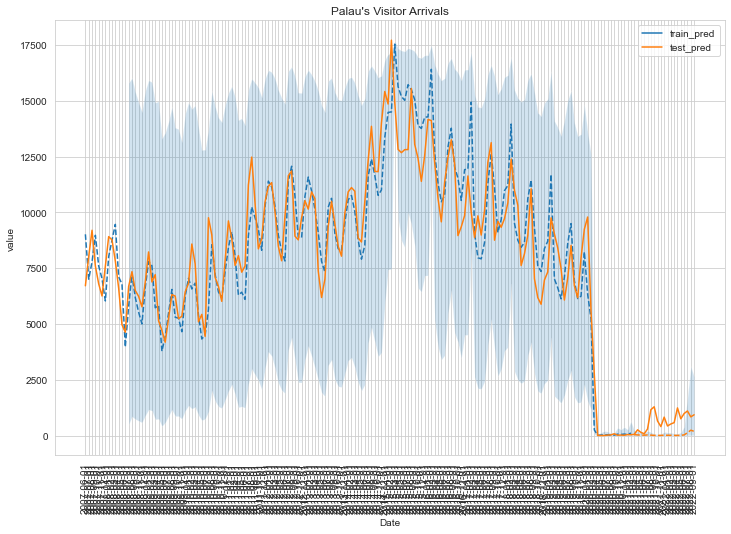

In [57]:
scaled_viz_df = (best_pw_mod[["Date", "train_pred", "test_pred"]]
                 .melt(id_vars=["Date"]))

# use the timezone object in your code
# scaled_viz_df["Date"] = pd.to_datetime(
#     scaled_viz_df["Date"], format="%Y-%m-%d")

import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(12, 8))
ax.fill_between(x="Date", y1="mean_ci_lower", y2="mean_ci_upper",
                data=best_pw_mod, alpha=0.2)
sns.lineplot(x="Date", y="value", data=scaled_viz_df,
             hue="variable", linestyle="--")
sns.lineplot(data=best_pw_mod, x="Date", y="Total")
plt.xticks(rotation=90)
plt.title("Palau's Visitor Arrivals")
plt.show()